### 1.读取数据

In [1]:
import pandas as pd

df = pd.read_excel(r".\multiRTP（no height split）-1.xlsx", index_col='NO.')
df

,H2SO4（μL）,Reacting Time（s）,Volume ratio of ethanol（%）,FL EM,RTP EM,Stokes Shift（FL）,Stokes Shift（RTP）
NO.,,,,,,,
1,200,70,0.00,381,494,25,124
2,200,80,0.00,382,496,36,127
3,200,90,0.00,387,500,37,126
4,200,100,0.00,389,494,32,118
5,200,110,0.00,392,492,38,120
...,...,...,...,...,...,...,...
206,800,90,0.75,487,509,46,166
207,800,100,0.75,518,524,48,178
208,800,110,0.75,516,518,49,166


### 2.数据预处理与可视化

In [2]:
# 查看是否有空值
df.isnull().sum()

H2SO4（μL）                     0
Reacting Time（s）              0
Volume ratio of ethanol（%）    0
FL EM                         0
RTP EM                        0
Stokes Shift（FL）              0
Stokes Shift（RTP）             0
dtype: int64

In [3]:
# IQR 方法基于数据的分位数计算，通常使用 1.5 倍 IQR 来确定异常值
def detect_outliers(df):
    # 计算 Q1 (25th percentile) 和 Q3 (75th percentile) 以及 IQR (Interquartile Range)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # 计算下限和上限
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 判断哪些数据是异常值
    outliers = ((df < lower_bound) | (df > upper_bound)).any(axis=1)

    # 提取包含异常值的行
    outlier_rows = df[outliers]
    
    return outlier_rows

# 检测并提取包含异常值的行
outliers = detect_outliers(df)
outliers

,H2SO4（μL）,Reacting Time（s）,Volume ratio of ethanol（%）,FL EM,RTP EM,Stokes Shift（FL）,Stokes Shift（RTP）
NO.,,,,,,,
89,500,110,0.333,464,494,85,150
132,650,120,0.500,466,498,90,152
133,650,130,0.500,466,496,88,150


#### 数据可视化

In [4]:
df.columns[4:]

Index(['RTP EM', 'Stokes Shift（FL）', 'Stokes Shift（RTP）'], dtype='object')

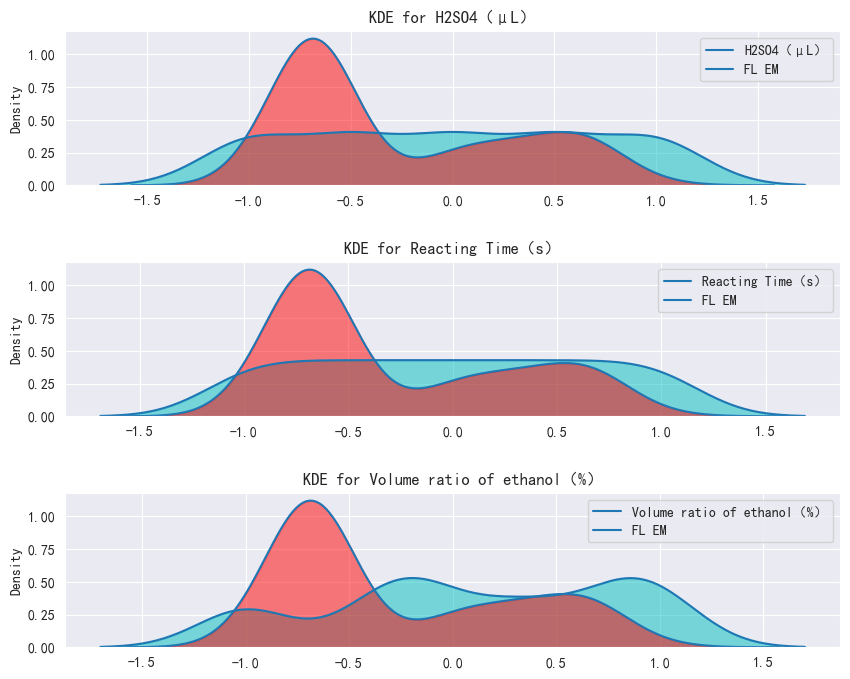

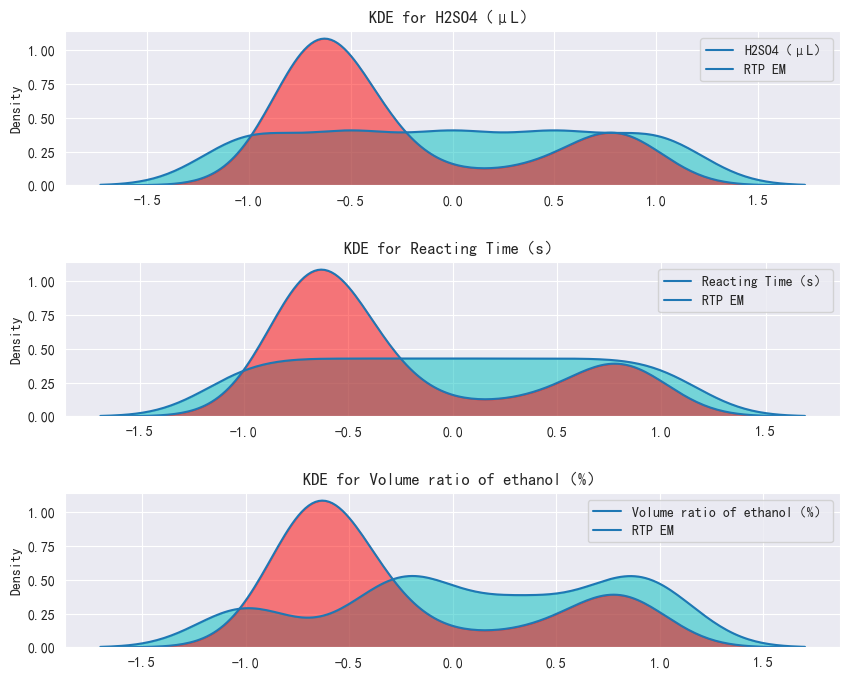

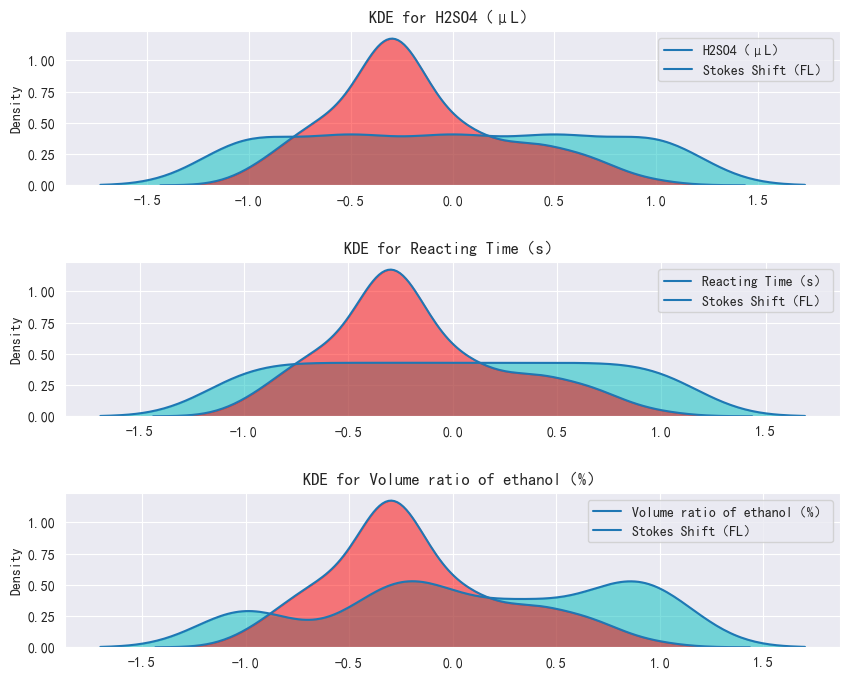

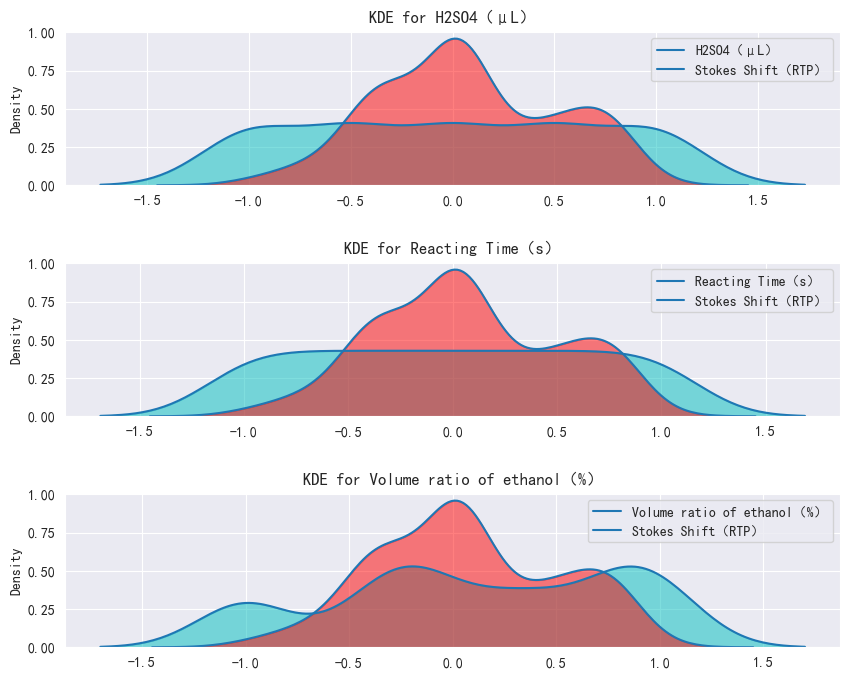

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

plt.rcParams["font.family"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False


# 画KDE图
def kdeplot(feature, df, ax, target):
    """考虑到某些列的差距巨大，因此我们对所有列进行映射"""
    scaler_1 = MinMaxScaler(feature_range=(-1, 1))
    scaler_2 = MinMaxScaler(feature_range=(-1, 1))
    df_raw = scaler_1.fit_transform(df[[feature]])
    df_target = scaler_2.fit_transform(df[[target]])
    ax.set_title("KDE for {}".format(feature))
    #绘制概率密度
    ax0 = sns.kdeplot(df_raw, color='c', label=f'{feature}', ax=ax)
    ax1 = sns.kdeplot(df_target, color='r', label=f'{target}', ax=ax)

    # F填充颜色
    ax0.fill_between(ax0.get_lines()[0].get_data()[0], ax0.get_lines()[0].get_data()[1], color='c', alpha=0.5)
    ax1.fill_between(ax1.get_lines()[1].get_data()[0], ax1.get_lines()[1].get_data()[1], color='r', alpha=0.5)
    ax.legend()  # Show the legend

for i in df.columns[3:]:
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.5)  # Adjust the spacing wspace=0.5,
    # 加载字典调用函数进行划分
    for feature, ax in zip(df.columns[:3], axes.flatten()):
        kdeplot(feature, df, ax, i)
    
    plt.savefig(f'./out/{i}_kde.png', dpi=300, bbox_inches='tight')
    plt.show()

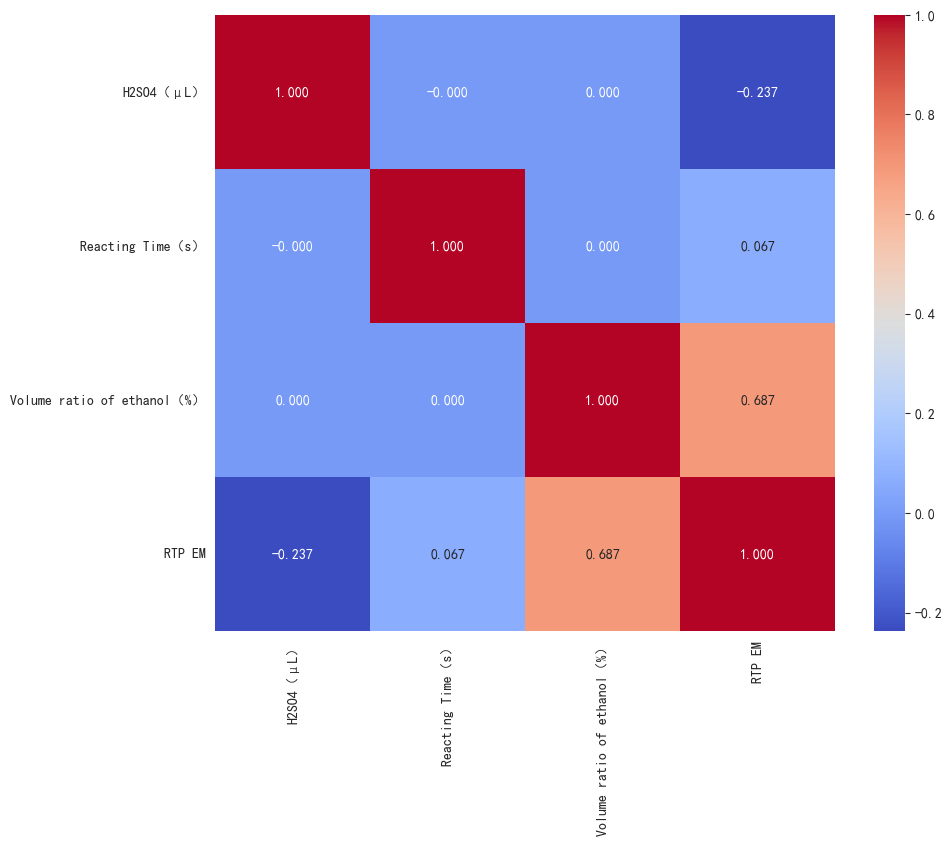

In [6]:
# 查看相关系数，只看与RTP EM的相关性
plt.figure(figsize=(10, 8))
cor_sj = df.iloc[:, [0, 1, 2, 4]].corr()  # method='spearman'
sns.heatmap(cor_sj, annot=True, cmap='coolwarm', fmt='.3f')
plt.savefig('./out/相关系数.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.以 FL EM 为因变量
#### xgboost模型

In [8]:
from sklearn.model_selection import KFold, cross_val_predict

X = df.iloc[:, [0, 1, 2]]
y = df['FL EM']

# 定义交叉验证策略
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):
    # 定义参数搜索空间
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 1e-3, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
    }

    # 创建 XGBoost 模型
    model = xgb.XGBRegressor(**params)

    # 使用交叉验证进行预测
    y_pred = cross_val_predict(model, X, y, cv=kf)
    return mean_squared_error(y, y_pred)


# 创建 Optuna 试验
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# 获取最优参数
best_params = study.best_params
print("最优参数:", best_params)

[I 2024-07-29 11:17:40,256] A new study created in memory with name: no-name-2a4dee4b-77e0-4d31-ba0c-285dfd99ee1a
[I 2024-07-29 11:17:41,081] Trial 5 finished with value: 2534.383235617718 and parameters: {'booster': 'gblinear', 'lambda': 0.7662713512914238, 'alpha': 0.2681841539227028, 'max_depth': 8, 'eta': 0.15393824599843076, 'gamma': 0.10766585988366359}. Best is trial 5 with value: 2534.383235617718.
[I 2024-07-29 11:17:41,088] Trial 3 finished with value: 1575.2263214720813 and parameters: {'booster': 'gblinear', 'lambda': 0.02616958799576169, 'alpha': 0.5217013841327408, 'max_depth': 7, 'eta': 0.18157058525161465, 'gamma': 0.19110547471649966}. Best is trial 3 with value: 1575.2263214720813.
[I 2024-07-29 11:17:41,104] Trial 19 finished with value: 2575.2891862536826 and parameters: {'booster': 'gblinear', 'lambda': 0.9310301555433894, 'alpha': 0.4654407345425878, 'max_depth': 3, 'eta': 0.7841061818231133, 'gamma': 0.746591861113205}. Best is trial 3 with value: 1575.2263214720

最优参数: {'booster': 'dart', 'lambda': 0.6225887279216917, 'alpha': 0.189151838586366, 'max_depth': 5, 'eta': 0.24096162435776397, 'gamma': 0.6915460149923942}


In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

def calculate_mape(y_true, y_pred):
    """计算mape"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# 使用最优参数重新训练模型
best_model_xgb = xgb.XGBRegressor(**best_params)
# 使用交叉验证进行预测
y_pred = cross_val_predict(best_model_xgb, X, y, cv=kf)

print("xgboost 5折交叉验证 的mse:", mean_squared_error(y, y_pred))
print("xgboost 5折交叉验证 的mae:", mean_absolute_error(y, y_pred))
print("xgboost 5折交叉验证 的r2:", r2_score(y, y_pred))
print("xgboost 5折交叉验证 的mape:", calculate_mape(y, y_pred))

xgboost 5折交叉验证 的mse: 138.95128795308992
xgboost 5折交叉验证 的mae: 6.945801798502604
xgboost 5折交叉验证 的r2: 0.9506256617875121
xgboost 5折交叉验证 的mape: 1.584083745799469


#### 随机森林模型

In [12]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    # 定义随机森林分类器的超参数搜索范围
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # 创建随机森林模型
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    # 使用交叉验证进行预测
    y_pred = cross_val_predict(model, X, y, cv=kf)
    return mean_squared_error(y, y_pred)

# 创建一个 Optuna 试验
study = optuna.create_study(direction='minimize')

# 运行 Optuna 试验
study.optimize(objective, n_trials=50, n_jobs=-1)

# 获取最优参数
best_params = study.best_params
print("最优参数:", best_params)

[I 2024-07-29 11:21:57,140] A new study created in memory with name: no-name-1cdc46e5-79e5-4898-aa16-fafc361d3628
[I 2024-07-29 11:22:06,363] Trial 1 finished with value: 497.52216931675736 and parameters: {'n_estimators': 138, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 1 with value: 497.52216931675736.
[I 2024-07-29 11:22:09,290] Trial 17 finished with value: 419.41542671783213 and parameters: {'n_estimators': 172, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 17 with value: 419.41542671783213.
[I 2024-07-29 11:22:09,423] Trial 8 finished with value: 499.3650860724172 and parameters: {'n_estimators': 183, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 17 with value: 419.41542671783213.
[I 2024-07-29 11:22:09,602] Trial 14 finished with value: 500.20489953701014 and parameters: {'n_estimators': 177, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 17 with v

最优参数: {'n_estimators': 406, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [13]:
# 使用最优参数重新训练模型
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],)

# 使用交叉验证进行预测
y_pred_rf = cross_val_predict(best_model, X, y, cv=kf)

print("rf 5折交叉验证 的mse:", mean_squared_error(y, y_pred_rf))
print("rf 5折交叉验证 的mae:", mean_absolute_error(y, y_pred_rf))
print("rf 5折交叉验证 的r2:", r2_score(y, y_pred_rf))
print("rf 5折交叉验证 的mape:", calculate_mape(y, y_pred_rf))

rf 5折交叉验证 的mse: 150.91987070200477
rf 5折交叉验证 的mae: 6.94368887426593
rf 5折交叉验证 的r2: 0.9463727983468466
rf 5折交叉验证 的mape: 1.5660081242745558


#### 所有指标合并评价

In [19]:
train_metrics = pd.DataFrame(
    {"mae": [round(mean_absolute_error(y, y_pred), 4), round(mean_absolute_error(y, y_pred_rf), 4)],
     "mse": [round(mean_squared_error(y, y_pred), 4), round(mean_squared_error(y, y_pred_rf), 4)],
     "r2": [round(r2_score(y, y_pred), 4), round(r2_score(y, y_pred_rf), 4)],
     "mape": [round(calculate_mape(y, y_pred), 4), round(calculate_mape(y, y_pred_rf), 4)]},)
train_metrics = train_metrics.T
train_metrics.columns = ['xgboost', 'rf']
train_metrics

,xgboost,rf
mae,6.9458,6.9437
mse,138.9513,150.9199
r2,0.9506,0.9464
mape,1.5841,1.5660


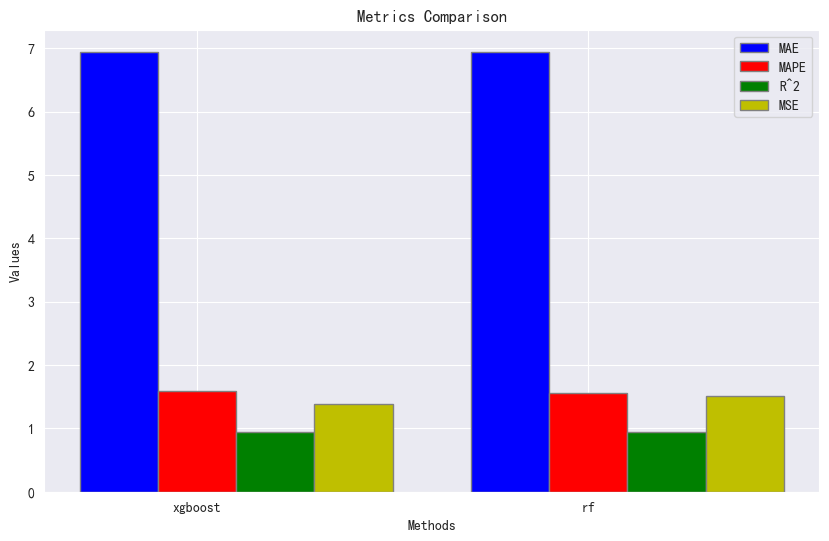

In [20]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置中文字体为黑体或其他已安装的中文字体
plt.rcParams['axes.unicode_minus'] = False

# 数据
labels = train_metrics.columns
mae_values = train_metrics.loc['mae']
mape_values = train_metrics.loc['mape']  
r2_values = train_metrics.loc['r2']
mse_values = train_metrics.loc['mse'] / 100 # 以便更好的观察

# 创建堆叠条形图
barWidth = 0.2
r1 = range(len(mae_values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 6))

plt.bar(r1, mae_values, color='b', width=barWidth, edgecolor='grey', label='MAE')
plt.bar(r2, mape_values, color='r', width=barWidth, edgecolor='grey', label='MAPE')
plt.bar(r3, r2_values, color='g', width=barWidth, edgecolor='grey', label='R^2')
plt.bar(r4, mse_values, color='y', width=barWidth, edgecolor='grey', label='MSE')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title('Metrics Comparison')
plt.xlabel('Methods', fontweight='bold')
plt.ylabel('Values')
plt.xticks([r + barWidth for r in range(len(mae_values))], labels)

plt.savefig('./out/FL EM_Metrics_Comparison.png')
# 显示图形
plt.show()

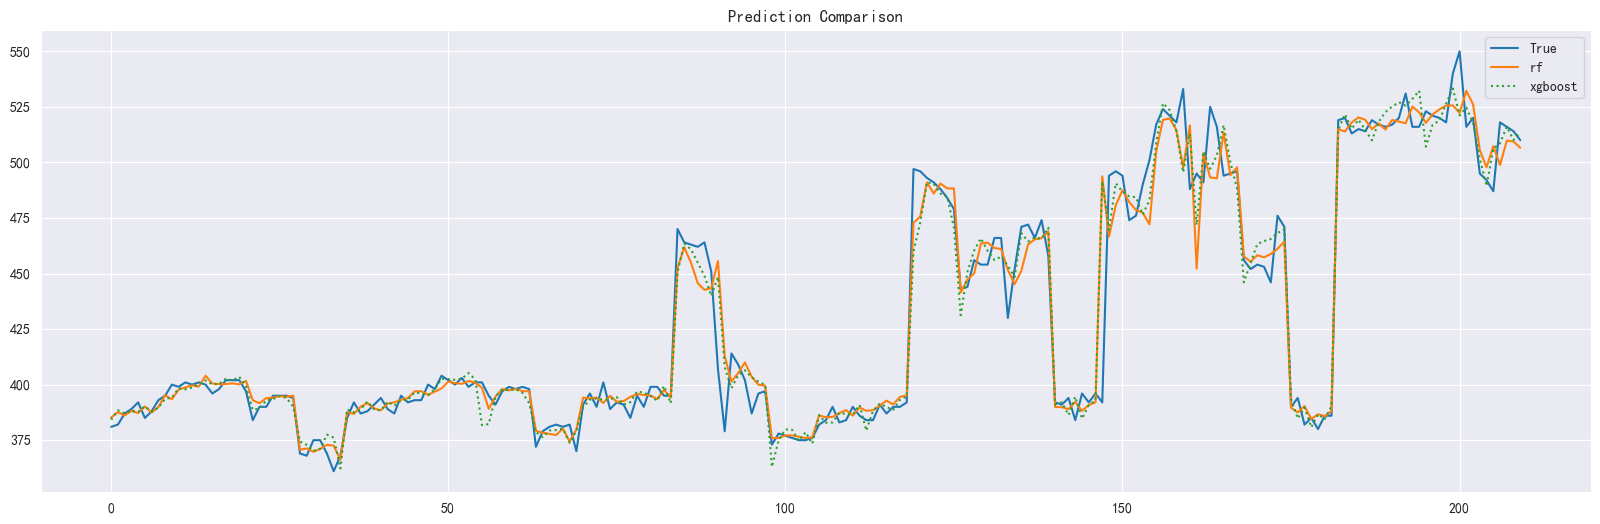

In [21]:
# 预测图对比，训练集
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(y.values, label='True')
plt.plot(y_pred_rf, label='rf', linestyle='-')
plt.plot(y_pred, label='xgboost', linestyle=':')  

plt.legend()
plt.title('Prediction Comparison')
plt.savefig('./out/FL EM_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.以 RTP EM 为因变量
#### xgboost模型

In [22]:
from sklearn.model_selection import KFold, cross_val_predict

X = df.iloc[:, [0, 1, 2]]
y = df['RTP EM']

# 定义交叉验证策略
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
def objective(trial):
    # 定义参数搜索空间
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 1e-3, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
    }

    # 创建 XGBoost 模型
    model = xgb.XGBRegressor(**params)

    # 使用交叉验证进行预测
    y_pred = cross_val_predict(model, X, y, cv=kf)
    return mean_squared_error(y, y_pred)


# 创建 Optuna 试验
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# 获取最优参数
best_params = study.best_params
print("最优参数:", best_params)

[I 2024-07-29 12:51:39,072] A new study created in memory with name: no-name-6b6d8a76-ace2-4661-85a4-ead414b96d0c
[I 2024-07-29 12:51:39,768] Trial 3 finished with value: 539.0958268039905 and parameters: {'booster': 'gblinear', 'lambda': 0.3831096720117438, 'alpha': 0.560331837126325, 'max_depth': 8, 'eta': 0.654712159655479, 'gamma': 0.5730415888402881}. Best is trial 3 with value: 539.0958268039905.
[I 2024-07-29 12:51:39,809] Trial 11 finished with value: 535.8276772544276 and parameters: {'booster': 'gblinear', 'lambda': 0.37292938387327124, 'alpha': 0.5722697292623554, 'max_depth': 5, 'eta': 0.3626660338409997, 'gamma': 0.6716382350006654}. Best is trial 11 with value: 535.8276772544276.
[I 2024-07-29 12:51:39,920] Trial 17 finished with value: 481.93969994954585 and parameters: {'booster': 'gblinear', 'lambda': 0.197527028705345, 'alpha': 0.24254948372602578, 'max_depth': 3, 'eta': 0.13335958451676524, 'gamma': 0.319944200075672}. Best is trial 17 with value: 481.93969994954585.

最优参数: {'booster': 'gbtree', 'lambda': 0.7765012375301126, 'alpha': 0.6372311391581545, 'max_depth': 6, 'eta': 0.16824990182973748, 'gamma': 0.5962356440863972}


In [24]:
# 使用最优参数重新训练模型
best_model_xgb = xgb.XGBRegressor(**best_params)
# 使用交叉验证进行预测
y_pred = cross_val_predict(best_model_xgb, X, y, cv=kf)

print("xgboost 5折交叉验证 的mse:", mean_squared_error(y, y_pred))
print("xgboost 5折交叉验证 的mae:", mean_absolute_error(y, y_pred))
print("xgboost 5折交叉验证 的r2:", r2_score(y, y_pred))
print("xgboost 5折交叉验证 的mape:", calculate_mape(y, y_pred))

xgboost 5折交叉验证 的mse: 71.99056769892839
xgboost 5折交叉验证 的mae: 5.469429670061384
xgboost 5折交叉验证 的r2: 0.8872679809052438
xgboost 5折交叉验证 的mape: 1.0621741105413938


#### 随机森林模型

In [25]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    # 定义随机森林分类器的超参数搜索范围
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # 创建随机森林模型
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    # 使用交叉验证进行预测
    y_pred = cross_val_predict(model, X, y, cv=kf)
    return mean_squared_error(y, y_pred)

# 创建一个 Optuna 试验
study = optuna.create_study(direction='minimize')

# 运行 Optuna 试验
study.optimize(objective, n_trials=50, n_jobs=-1)

# 获取最优参数
best_params = study.best_params
print("最优参数:", best_params)

[I 2024-07-29 12:51:58,171] A new study created in memory with name: no-name-64242555-fb05-4697-a814-7d563a8abea9
[I 2024-07-29 12:52:06,166] Trial 19 finished with value: 92.52370421135026 and parameters: {'n_estimators': 124, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 19 with value: 92.52370421135026.
[I 2024-07-29 12:52:08,797] Trial 1 finished with value: 84.7825168313041 and parameters: {'n_estimators': 174, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 1 with value: 84.7825168313041.
[I 2024-07-29 12:52:10,149] Trial 17 finished with value: 101.42971294986947 and parameters: {'n_estimators': 224, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 84.7825168313041.
[I 2024-07-29 12:52:11,134] Trial 13 finished with value: 84.97176283038752 and parameters: {'n_estimators': 193, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 1 with value: 8

最优参数: {'n_estimators': 970, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2}


In [26]:
# 使用最优参数重新训练模型
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],)

# 使用交叉验证进行预测
y_pred_rf = cross_val_predict(best_model, X, y, cv=kf)

print("rf 5折交叉验证 的mse:", mean_squared_error(y, y_pred_rf))
print("rf 5折交叉验证 的mae:", mean_absolute_error(y, y_pred_rf))
print("rf 5折交叉验证 的r2:", r2_score(y, y_pred_rf))
print("rf 5折交叉验证 的mape:", calculate_mape(y, y_pred_rf))

rf 5折交叉验证 的mse: 64.58859746548005
rf 5折交叉验证 的mae: 5.131785482613132
rf 5折交叉验证 的r2: 0.8988589306139004
rf 5折交叉验证 的mape: 0.9984138147220286


#### 所有指标合并评价

In [27]:
train_metrics = pd.DataFrame(
    {"mae": [round(mean_absolute_error(y, y_pred), 4), round(mean_absolute_error(y, y_pred_rf), 4)],
     "mse": [round(mean_squared_error(y, y_pred), 4), round(mean_squared_error(y, y_pred_rf), 4)],
     "r2": [round(r2_score(y, y_pred), 4), round(r2_score(y, y_pred_rf), 4)],
     "mape": [round(calculate_mape(y, y_pred), 4), round(calculate_mape(y, y_pred_rf), 4)]},)
train_metrics = train_metrics.T
train_metrics.columns = ['xgboost', 'rf']
train_metrics

,xgboost,rf
mae,5.4694,5.1318
mse,71.9906,64.5886
r2,0.8873,0.8989
mape,1.0622,0.9984


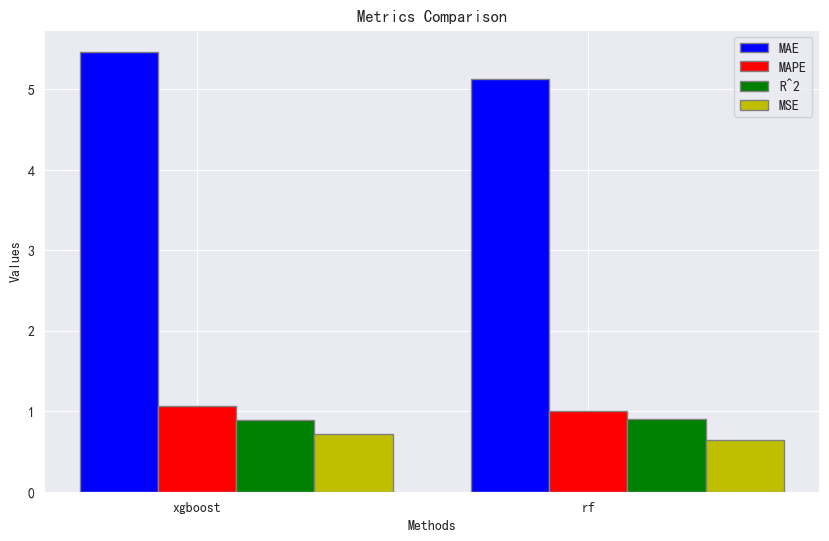

In [28]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置中文字体为黑体或其他已安装的中文字体
plt.rcParams['axes.unicode_minus'] = False

# 数据
labels = train_metrics.columns
mae_values = train_metrics.loc['mae']
mape_values = train_metrics.loc['mape']  
r2_values = train_metrics.loc['r2']
mse_values = train_metrics.loc['mse'] / 100 # 以便更好的观察

# 创建堆叠条形图
barWidth = 0.2
r1 = range(len(mae_values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 6))

plt.bar(r1, mae_values, color='b', width=barWidth, edgecolor='grey', label='MAE')
plt.bar(r2, mape_values, color='r', width=barWidth, edgecolor='grey', label='MAPE')
plt.bar(r3, r2_values, color='g', width=barWidth, edgecolor='grey', label='R^2')
plt.bar(r4, mse_values, color='y', width=barWidth, edgecolor='grey', label='MSE')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title('Metrics Comparison')
plt.xlabel('Methods', fontweight='bold')
plt.ylabel('Values')
plt.xticks([r + barWidth for r in range(len(mae_values))], labels)

plt.savefig('./out/RTP EM_Metrics_Comparison.png')
# 显示图形
plt.show()

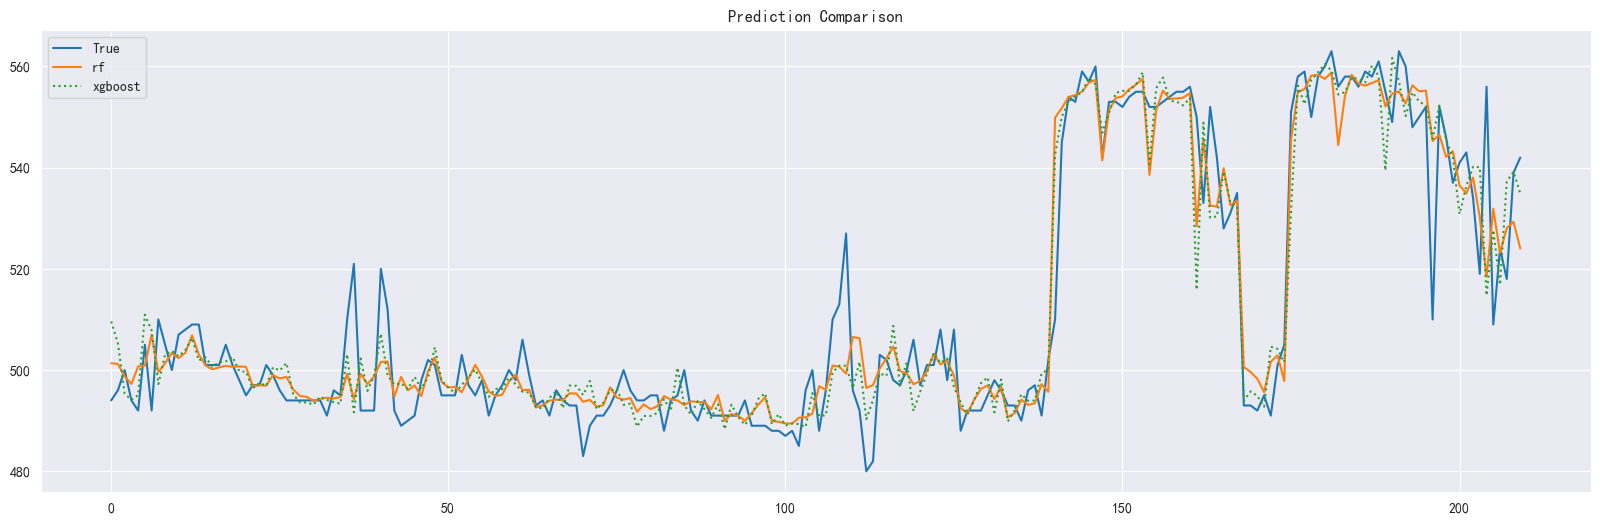

In [29]:
# 预测图对比，训练集
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(y.values, label='True')
plt.plot(y_pred_rf, label='rf', linestyle='-')
plt.plot(y_pred, label='xgboost', linestyle=':')  

plt.legend()
plt.title('Prediction Comparison')
plt.savefig('./out/RTP EM_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.以 Stokes Shift（FL） 为因变量
#### xgboost模型

In [32]:
from sklearn.model_selection import KFold, cross_val_predict

X = df.iloc[:, [0, 1, 2]]
y = df['Stokes Shift（FL）']

# 定义交叉验证策略
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
def objective(trial):
    # 定义参数搜索空间
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 1e-3, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
    }

    # 创建 XGBoost 模型
    model = xgb.XGBRegressor(**params)

    # 使用交叉验证进行预测
    y_pred = cross_val_predict(model, X, y, cv=kf)
    return mean_squared_error(y, y_pred)


# 创建 Optuna 试验
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# 获取最优参数
best_params = study.best_params
print("最优参数:", best_params)

[I 2024-07-29 13:09:03,900] A new study created in memory with name: no-name-fc6c8c21-7583-4c5b-bc83-2943e83ad294
[I 2024-07-29 13:09:04,984] Trial 3 finished with value: 147.07472697010851 and parameters: {'booster': 'gblinear', 'lambda': 0.050833842702713614, 'alpha': 0.2810406779199395, 'max_depth': 3, 'eta': 0.09227090560074729, 'gamma': 0.8672045949221981}. Best is trial 3 with value: 147.07472697010851.
[I 2024-07-29 13:09:05,003] Trial 5 finished with value: 135.74467230680978 and parameters: {'booster': 'gblinear', 'lambda': 0.311164307478334, 'alpha': 0.3991441916013978, 'max_depth': 4, 'eta': 0.7092026214399241, 'gamma': 0.6478165393259001}. Best is trial 5 with value: 135.74467230680978.
[I 2024-07-29 13:09:05,016] Trial 6 finished with value: 161.5386544716819 and parameters: {'booster': 'gblinear', 'lambda': 0.9125411464969229, 'alpha': 0.6313291031086307, 'max_depth': 8, 'eta': 0.04349158899807157, 'gamma': 0.8303745952978335}. Best is trial 5 with value: 135.744672306809

最优参数: {'booster': 'dart', 'lambda': 0.7018790109841745, 'alpha': 0.7388845236062077, 'max_depth': 5, 'eta': 0.28437042170368987, 'gamma': 0.33857226330591883}


In [34]:
# 使用最优参数重新训练模型
best_model_xgb = xgb.XGBRegressor(**best_params)
# 使用交叉验证进行预测
y_pred = cross_val_predict(best_model_xgb, X, y, cv=kf)

print("xgboost 5折交叉验证 的mse:", mean_squared_error(y, y_pred))
print("xgboost 5折交叉验证 的mae:", mean_absolute_error(y, y_pred))
print("xgboost 5折交叉验证 的r2:", r2_score(y, y_pred))
print("xgboost 5折交叉验证 的mape:", calculate_mape(y, y_pred))

xgboost 5折交叉验证 的mse: 48.710363024783284
xgboost 5折交叉验证 的mae: 5.322651181902204
xgboost 5折交叉验证 的r2: 0.748330738365092
xgboost 5折交叉验证 的mape: 11.367898145872006


#### 随机森林模型

In [35]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    # 定义随机森林分类器的超参数搜索范围
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # 创建随机森林模型
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    # 使用交叉验证进行预测
    y_pred = cross_val_predict(model, X, y, cv=kf)
    return mean_squared_error(y, y_pred)

# 创建一个 Optuna 试验
study = optuna.create_study(direction='minimize')

# 运行 Optuna 试验
study.optimize(objective, n_trials=50, n_jobs=-1)

# 获取最优参数
best_params = study.best_params
print("最优参数:", best_params)

[I 2024-07-29 13:09:17,926] A new study created in memory with name: no-name-5f49b169-682a-42ef-a266-03435c9aea3d
[I 2024-07-29 13:09:28,579] Trial 0 finished with value: 51.66323563951968 and parameters: {'n_estimators': 123, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 51.66323563951968.
[I 2024-07-29 13:09:29,426] Trial 1 finished with value: 58.12086904453418 and parameters: {'n_estimators': 154, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 51.66323563951968.
[I 2024-07-29 13:09:33,647] Trial 3 finished with value: 46.84617787699695 and parameters: {'n_estimators': 141, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 3 with value: 46.84617787699695.
[I 2024-07-29 13:09:34,067] Trial 18 finished with value: 59.92499430253944 and parameters: {'n_estimators': 202, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 3 with value: 46.8

最优参数: {'n_estimators': 501, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [36]:
# 使用最优参数重新训练模型
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],)

# 使用交叉验证进行预测
y_pred_rf = cross_val_predict(best_model, X, y, cv=kf)

print("rf 5折交叉验证 的mse:", mean_squared_error(y, y_pred_rf))
print("rf 5折交叉验证 的mae:", mean_absolute_error(y, y_pred_rf))
print("rf 5折交叉验证 的r2:", r2_score(y, y_pred_rf))
print("rf 5折交叉验证 的mape:", calculate_mape(y, y_pred_rf))

rf 5折交叉验证 的mse: 44.47764070318969
rf 5折交叉验证 的mae: 4.928396419556954
rf 5折交叉验证 的r2: 0.7701997213747047
rf 5折交叉验证 的mape: 10.391382415123113


#### 所有指标合并评价

In [37]:
train_metrics = pd.DataFrame(
    {"mae": [round(mean_absolute_error(y, y_pred), 4), round(mean_absolute_error(y, y_pred_rf), 4)],
     "mse": [round(mean_squared_error(y, y_pred), 4), round(mean_squared_error(y, y_pred_rf), 4)],
     "r2": [round(r2_score(y, y_pred), 4), round(r2_score(y, y_pred_rf), 4)],
     "mape": [round(calculate_mape(y, y_pred), 4), round(calculate_mape(y, y_pred_rf), 4)]},)
train_metrics = train_metrics.T
train_metrics.columns = ['xgboost', 'rf']
train_metrics

,xgboost,rf
mae,5.3227,4.9284
mse,48.7104,44.4776
r2,0.7483,0.7702
mape,11.3679,10.3914


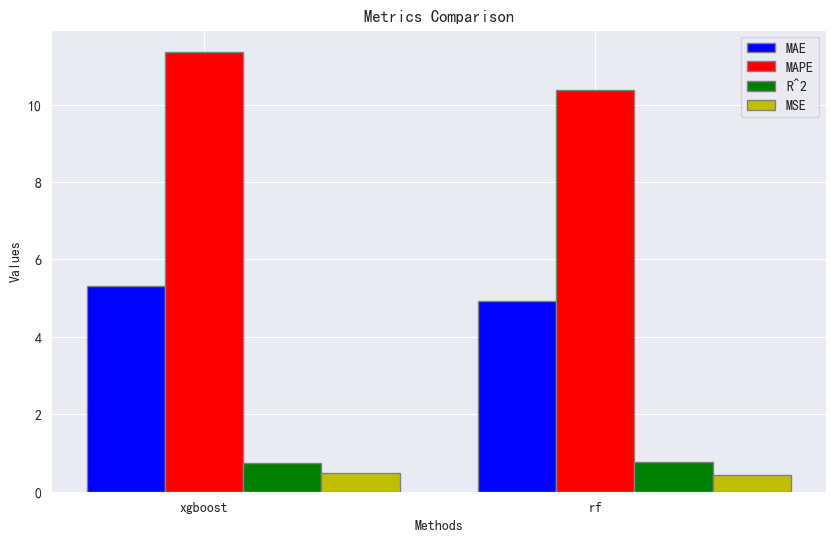

In [38]:
# 数据
labels = train_metrics.columns
mae_values = train_metrics.loc['mae']
mape_values = train_metrics.loc['mape']  
r2_values = train_metrics.loc['r2']
mse_values = train_metrics.loc['mse'] / 100 # 以便更好的观察

# 创建堆叠条形图
barWidth = 0.2
r1 = range(len(mae_values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 6))

plt.bar(r1, mae_values, color='b', width=barWidth, edgecolor='grey', label='MAE')
plt.bar(r2, mape_values, color='r', width=barWidth, edgecolor='grey', label='MAPE')
plt.bar(r3, r2_values, color='g', width=barWidth, edgecolor='grey', label='R^2')
plt.bar(r4, mse_values, color='y', width=barWidth, edgecolor='grey', label='MSE')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title('Metrics Comparison')
plt.xlabel('Methods', fontweight='bold')
plt.ylabel('Values')
plt.xticks([r + barWidth for r in range(len(mae_values))], labels)

plt.savefig('./out/Stokes Shift（FL）_Metrics_Comparison.png')
# 显示图形
plt.show()

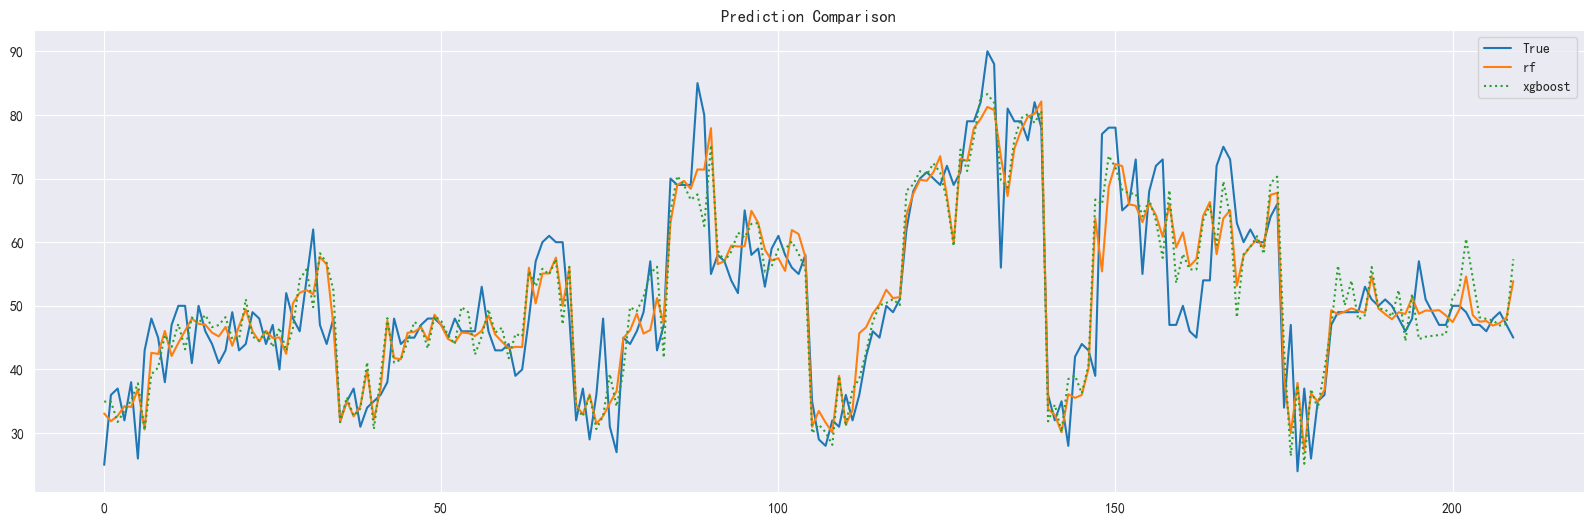

In [39]:
# 预测图对比，训练集
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(y.values, label='True')
plt.plot(y_pred_rf, label='rf', linestyle='-')
plt.plot(y_pred, label='xgboost', linestyle=':')  

plt.legend()
plt.title('Prediction Comparison')
plt.savefig('./out/Stokes Shift（FL）_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.以 Stokes Shift（RTP） 为因变量
#### xgboost模型

In [40]:
from sklearn.model_selection import KFold, cross_val_predict

X = df.iloc[:, [0, 1, 2]]
y = df['Stokes Shift（RTP）']

# 定义交叉验证策略
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
def objective(trial):
    # 定义参数搜索空间
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 1e-3, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
    }

    # 创建 XGBoost 模型
    model = xgb.XGBRegressor(**params)

    # 使用交叉验证进行预测
    y_pred = cross_val_predict(model, X, y, cv=kf)
    return mean_squared_error(y, y_pred)


# 创建 Optuna 试验
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# 获取最优参数
best_params = study.best_params
print("最优参数:", best_params)

[I 2024-07-29 13:17:59,858] A new study created in memory with name: no-name-9088f183-0a9b-4c20-9118-b092c12de006
[I 2024-07-29 13:18:00,766] Trial 0 finished with value: 497.8229356097324 and parameters: {'booster': 'gblinear', 'lambda': 0.6432918273492709, 'alpha': 0.24990386901672765, 'max_depth': 7, 'eta': 0.3031163082959406, 'gamma': 0.6747160780857095}. Best is trial 0 with value: 497.8229356097324.
[I 2024-07-29 13:18:00,817] Trial 10 finished with value: 507.35777768595585 and parameters: {'booster': 'gblinear', 'lambda': 0.8449016621835604, 'alpha': 0.1133177119786807, 'max_depth': 4, 'eta': 0.39242979337722755, 'gamma': 0.6794886408299019}. Best is trial 0 with value: 497.8229356097324.
[I 2024-07-29 13:18:00,829] Trial 3 finished with value: 518.7015077283073 and parameters: {'booster': 'gblinear', 'lambda': 0.9576065577491614, 'alpha': 0.9389515693167019, 'max_depth': 7, 'eta': 0.6055848097172433, 'gamma': 0.7190886806329615}. Best is trial 0 with value: 497.8229356097324.


最优参数: {'booster': 'dart', 'lambda': 0.7506902911673075, 'alpha': 0.4370373363083222, 'max_depth': 6, 'eta': 0.04347837317637748, 'gamma': 0.9638737464424914}


In [42]:
# 使用最优参数重新训练模型
best_model_xgb = xgb.XGBRegressor(**best_params)
# 使用交叉验证进行预测
y_pred = cross_val_predict(best_model_xgb, X, y, cv=kf)

print("xgboost 5折交叉验证 的mse:", mean_squared_error(y, y_pred))
print("xgboost 5折交叉验证 的mae:", mean_absolute_error(y, y_pred))
print("xgboost 5折交叉验证 的r2:", r2_score(y, y_pred))
print("xgboost 5折交叉验证 的mape:", calculate_mape(y, y_pred))

xgboost 5折交叉验证 的mse: 65.09607506011325
xgboost 5折交叉验证 的mae: 5.572104245140439
xgboost 5折交叉验证 的r2: 0.8831280507086324
xgboost 5折交叉验证 的mape: 3.869642329685039


#### 随机森林模型

In [43]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    # 定义随机森林分类器的超参数搜索范围
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # 创建随机森林模型
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    # 使用交叉验证进行预测
    y_pred = cross_val_predict(model, X, y, cv=kf)
    return mean_squared_error(y, y_pred)

# 创建一个 Optuna 试验
study = optuna.create_study(direction='minimize')

# 运行 Optuna 试验
study.optimize(objective, n_trials=50, n_jobs=-1)

# 获取最优参数
best_params = study.best_params
print("最优参数:", best_params)

[I 2024-07-29 13:18:13,204] A new study created in memory with name: no-name-433c0fb7-9b3b-4a61-8a4e-58ac75ec8a13
[I 2024-07-29 13:18:25,744] Trial 12 finished with value: 67.9649970289925 and parameters: {'n_estimators': 138, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 12 with value: 67.9649970289925.
[I 2024-07-29 13:18:28,869] Trial 13 finished with value: 77.62890444616212 and parameters: {'n_estimators': 222, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 12 with value: 67.9649970289925.
[I 2024-07-29 13:18:31,500] Trial 15 finished with value: 85.33409601215286 and parameters: {'n_estimators': 323, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 12 with value: 67.9649970289925.
[I 2024-07-29 13:18:36,633] Trial 21 finished with value: 83.1682175375623 and parameters: {'n_estimators': 125, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 12 with value: 6

最优参数: {'n_estimators': 677, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}


In [44]:
# 使用最优参数重新训练模型
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],)

# 使用交叉验证进行预测
y_pred_rf = cross_val_predict(best_model, X, y, cv=kf)

print("rf 5折交叉验证 的mse:", mean_squared_error(y, y_pred_rf))
print("rf 5折交叉验证 的mae:", mean_absolute_error(y, y_pred_rf))
print("rf 5折交叉验证 的r2:", r2_score(y, y_pred_rf))
print("rf 5折交叉验证 的mape:", calculate_mape(y, y_pred_rf))

rf 5折交叉验证 的mse: 65.49567781943716
rf 5折交叉验证 的mae: 5.307504235173042
rf 5折交叉验证 的r2: 0.8824106133918469
rf 5折交叉验证 的mape: 3.745430914767515


#### 所有指标合并评价

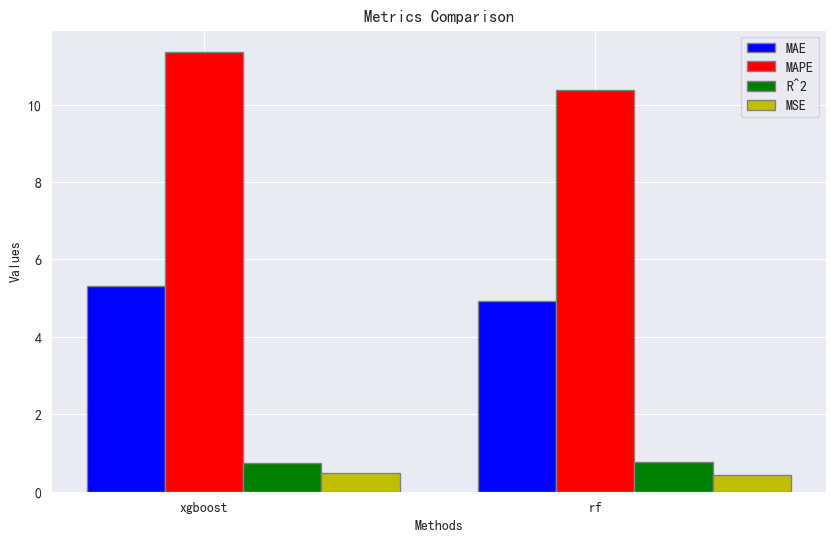

In [45]:
# 数据
labels = train_metrics.columns
mae_values = train_metrics.loc['mae']
mape_values = train_metrics.loc['mape']  
r2_values = train_metrics.loc['r2']
mse_values = train_metrics.loc['mse'] / 100 # 以便更好的观察

# 创建堆叠条形图
barWidth = 0.2
r1 = range(len(mae_values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 6))

plt.bar(r1, mae_values, color='b', width=barWidth, edgecolor='grey', label='MAE')
plt.bar(r2, mape_values, color='r', width=barWidth, edgecolor='grey', label='MAPE')
plt.bar(r3, r2_values, color='g', width=barWidth, edgecolor='grey', label='R^2')
plt.bar(r4, mse_values, color='y', width=barWidth, edgecolor='grey', label='MSE')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title('Metrics Comparison')
plt.xlabel('Methods', fontweight='bold')
plt.ylabel('Values')
plt.xticks([r + barWidth for r in range(len(mae_values))], labels)

plt.savefig('./out/Stokes Shift（RTP）_Metrics_Comparison.png')
# 显示图形
plt.show()

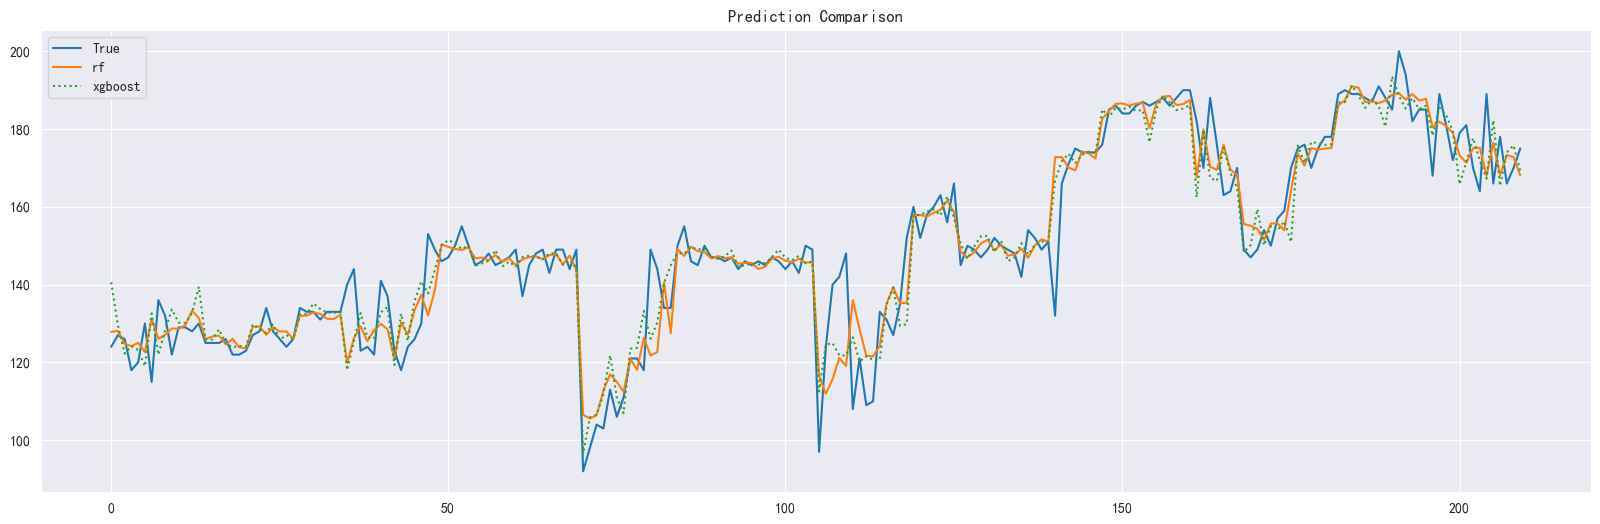

In [46]:
# 预测图对比，训练集
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(y.values, label='True')
plt.plot(y_pred_rf, label='rf', linestyle='-')
plt.plot(y_pred, label='xgboost', linestyle=':')  

plt.legend()
plt.title('Prediction Comparison')
plt.savefig('./out/Stokes Shift（RTP）_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()